We first import the packages we need as well as the data from the previous step.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime
import statsmodels.api as sm
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import timeit

Init Plugin
Init Graph Optimizer
Init Kernel


/Users/alalipour/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('Chicago_crime_data_ready_for_preprocessing.csv')

In [3]:
pd.set_option('display.max_columns', 500)
df.head()

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,10224738,HY411648,2015-09-05 13:30:00,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,1165074.0,1875917.0,2015,2018-02-10 15:50:01,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,1,10224739,HY411615,2015-09-04 11:30:00,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,1138875.0,1904869.0,2015,2018-02-10 15:50:01,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,2,11646166,JC213529,2018-09-01 00:01:00,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,631,6.0,8.0,44.0,06,NaN,NaN,2018,2019-04-06 16:04:43,NaN,NaN,NaN
3,3,10224740,HY411595,2015-09-05 12:45:00,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,1152037.0,1920384.0,2015,2018-02-10 15:50:01,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,4,10224741,HY411610,2015-09-05 13:00:00,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,1141706.0,1900086.0,2015,2018-02-10 15:50:01,41.881903,-87.755121,"(41.881903443, -87.755121152)"


We then perform feature engineering and add a column indicating whether a date is a holiday or not.

In [4]:
df['day_of_year'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timetuple().tm_yday)

In [5]:
df['day_of_year_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365))
df['day_of_year_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365))

In [6]:
df['day_of_week'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timetuple().tm_wday)

In [7]:
df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 6))
df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 6))

In [8]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start='2000-01-01', end='2022-12-31').to_pydatetime()
holidays = [x.strftime('%Y-%m-%d') for x in holidays]
df['holiday'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S')).dt.strftime('%Y-%m-%d')\
                                                                    .isin(holidays)

Text(0.5, 1.0, 'Day of week signal')

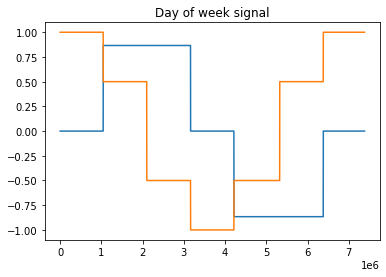

In [9]:
dftemp = df.sort_values('day_of_week')
plt.plot(np.array(dftemp['day_of_week_sin']))
plt.plot(np.array(dftemp['day_of_week_cos']))
plt.title('Day of week signal')

Text(0.5, 1.0, 'Day of year signal')

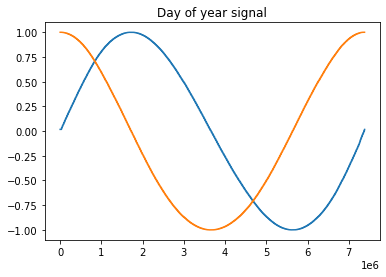

In [10]:
dftemp = df.sort_values('day_of_year')
plt.plot(np.array(dftemp['day_of_year_sin']))
plt.plot(np.array(dftemp['day_of_year_cos']))
plt.title('Day of year signal')

In [11]:
df['Date_only'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))\
                                                               .dt.strftime('%Y-%m-%d')

We count the number of criminal incidents per day and create a new dataframe containing only the features we will use in modeling.

In [12]:
crime_count = df.groupby('Date_only')['ID'].count()

In [13]:
df_new = df
df_new['Date'] = pd.to_datetime(df_new['Date'])
df_new = df_new.set_index('Date')
df_new = df_new.resample('D').first()

In [14]:
df_new['crime_count'] = crime_count.values

In [15]:
df_new = df_new[['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
                 'day_of_week_cos', 'holiday', 'crime_count']]

In [16]:
df_new.head(7)

,day_of_year_sin,day_of_year_cos,day_of_week_sin,day_of_week_cos,holiday,crime_count
Date,,,,,,
2001-01-01,0.017213,0.999852,0.000000e+00,1.0,True,1821
2001-01-02,0.034422,0.999407,8.660254e-01,0.5,False,1143
2001-01-03,0.051620,0.998667,8.660254e-01,-0.5,False,1151
2001-01-04,0.068802,0.997630,1.224647e-16,-1.0,False,1166
2001-01-05,0.085965,0.996298,-8.660254e-01,-0.5,False,1267
2001-01-06,0.103102,0.994671,-8.660254e-01,0.5,False,1290
2001-01-07,0.120208,0.992749,-2.449294e-16,1.0,False,1105


We perform Dickey–Fuller test to see if the data are stationary.

In [17]:
sm.tsa.stattools.adfuller(df_new['crime_count'])

(-1.7638730462036776,
 0.39853941043370816,
 36,
 7492,
 {'1%': -3.4312231369378514,
  '5%': -2.8619258603643205,
  '10%': -2.566975389072779},
 87896.40985788655)

Since the p-value is really high, we cannot reject the null hypothesis that the data are nonstationary. So, we take the difference between crime counts to make the data stationary and use that for modeling.

In [18]:
df_new['crime_count_diff'] = df_new['crime_count'].diff()

In [19]:
df_new = df_new.dropna()

In [20]:
sm.tsa.stattools.adfuller(df_new['crime_count_diff'])

(-16.437227813450257,
 2.4468521728369865e-29,
 36,
 7491,
 {'1%': -3.4312232535359573,
  '5%': -2.8619259118842773,
  '10%': -2.566975416497572},
 87878.7083241803)

The following cells (21-27) have been copied from tensorflow website (link below, accessed in September 2021) and sometimes modified to be used for our particualr project.
https://www.tensorflow.org/tutorials/structured_data/time_series

We first split the data into training, validation and test sets.

In [21]:
column_indices = {name: i for i, name in enumerate(df_new.drop(columns='crime_count').columns)}

n = len(df_new)
train_df = df_new.drop(columns='crime_count')[0:int(n*0.7)]
val_df = df_new.drop(columns='crime_count')[int(n*0.7):int(n*0.9)]
test_df = df_new.drop(columns='crime_count')[int(n*0.9):]

num_features = df_new.drop(columns='crime_count').shape[1]

We then normalize the data.

In [22]:
train_mean = train_df.loc[:,['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
                 'day_of_week_cos', 'crime_count_diff']].mean()
train_std = train_df.loc[:,['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
                 'day_of_week_cos', 'crime_count_diff']].std()

train_df.loc[:,['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
                 'day_of_week_cos', 'crime_count_diff']] = \
(train_df.loc[:,['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
                 'day_of_week_cos', 'crime_count_diff']] - train_mean) / train_std

val_df.loc[:,['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
                 'day_of_week_cos', 'crime_count_diff']] = \
(val_df.loc[:,['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
               'day_of_week_cos', 'crime_count_diff']] - train_mean) / train_std

test_df.loc[:,['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
                 'day_of_week_cos', 'crime_count_diff']] = \
(test_df.loc[:,['day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', \
                'day_of_week_cos', 'crime_count_diff']] - train_mean) / train_std

We create a window generator class and prepare data for tensorflow in the form of 32 batches.

In [23]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [24]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [25]:
def plot(self, model=None, plot_col='crime_count_diff', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [day]')

WindowGenerator.plot = plot

In [26]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [27]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

For each of the 32 batches for modeling with tensorflow, we create a window of 120 days as inputs (historical crime rate and the other 5 features) and 60 days as labels (crime rate to be estimated). Given the limited computational capacity available, we do not try other window sizes.

We create an LSTM model and do a manual grid search. We record the performance of different models.

In [28]:
Max_Epochs = [20]
Optimizer = [tf.optimizers.Adam, tf.optimizers.RMSprop, tf.optimizers.SGD]
Lstm_Kernel_Initializer = [tf.initializers.glorot_uniform, tf.initializers.random_normal]
Kernel_Initializer = [tf.initializers.random_uniform, tf.initializers.random_normal]
Learning_Rate = [0.003, 0.001]
Dropout_Rate = [0.0, 0.1]
Label_Width = [60]
Input_Width = [120]
model_perform = pd.DataFrame(columns=['MAE_train' , 'MAE_val', 'MAE_test', 'input_width',\
    'label_width', 'dropout_rate', 'learning_rate', 'kernel_initializer', \
    'lstm_kernel_initializer', 'optimizer', 'max_epochs'])

tic = timeit.default_timer()
for input_width in Input_Width:
    for label_width in Label_Width:
        for dropout_rate in Dropout_Rate:
            for learning_rate in Learning_Rate:
                for kernel_initializer in Kernel_Initializer:
                    for lstm_kernel_initializer in Lstm_Kernel_Initializer:
                        for optimizer in Optimizer:
                            for max_epochs in Max_Epochs:
                                
                                window = WindowGenerator(
                                input_width=input_width, label_width=label_width, shift=60,
                                label_columns=['crime_count_diff'])
                                
                                model = tf.keras.Sequential([
                                tf.keras.layers.LSTM(32, kernel_initializer=lstm_kernel_initializer, 
                                return_sequences=False, dropout=dropout_rate),
                                tf.keras.layers.Dense(60, kernel_initializer=kernel_initializer),
                                tf.keras.layers.Reshape([60, 1])])
                                
                                early_stopping = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=2, mode='min')
                                
                                model.compile(loss=tf.losses.MeanSquaredError(),
                                optimizer=optimizer(learning_rate),
                                metrics=[tf.metrics.MeanAbsoluteError()])
                                
                                history = model.fit(window.train, epochs=max_epochs,
                                validation_data=window.val,
                                callbacks=[early_stopping], verbose=0)
                                
                                temp = pd.DataFrame({
                                'MAE_train': [model.evaluate(window.train, verbose=0)[1]],
                                'MAE_val': [model.evaluate(window.val, verbose=0)[1]],
                                'MAE_test': [model.evaluate(window.test, verbose=0)[1]],
                                'input_width': [input_width],
                                'label_width': [label_width], 
                                'dropout_rate': [dropout_rate],
                                'learning_rate': [learning_rate], 
                                'kernel_initializer': [kernel_initializer],
                                'lstm_kernel_initializer': [lstm_kernel_initializer], 
                                'optimizer': [optimizer],
                                'max_epochs': [max_epochs]
                                })
                                
                                model_perform = model_perform.append(temp)
                                
                                
toc = timeit.default_timer()

print('Time elapsed in minutes:', (toc - tic)/60)

Metal device set to: Apple M1
Time elapsed in minutes: 156.55451757291667


In [35]:
model_perform.head()

,MAE_train,MAE_val,MAE_test,input_width,label_width,dropout_rate,learning_rate,kernel_initializer,lstm_kernel_initializer,optimizer,max_epochs
0,0.612623,0.481392,0.473135,120,60,0.0,0.003,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.optimizer_v2.a...,20
0,0.613757,0.484771,0.502652,120,60,0.0,0.003,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.optimizer_v2.r...,20
0,0.703558,0.465442,0.419476,120,60,0.0,0.003,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.optimizer_v2.g...,20
0,0.608941,0.452630,0.433497,120,60,0.0,0.003,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.optimizer_v2.a...,20
0,0.607011,0.449951,0.427773,120,60,0.0,0.003,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.initializers.i...,<class 'tensorflow.python.keras.optimizer_v2.r...,20


In [36]:
model_perform[model_perform['MAE_val'] == model_perform['MAE_val'].min()].to_numpy()

array([[0.6072983741760254, 0.4491587579250335, 0.4286886155605316, 120,
        60, 0.0, 0.003,
        "<class 'tensorflow.python.keras.initializers.initializers_v2.RandomNormal'>",
        "<class 'tensorflow.python.keras.initializers.initializers_v2.RandomNormal'>",
        "<class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>", 20]],
      dtype=object)

In [37]:
model_perform[model_perform['MAE_test'] == model_perform['MAE_test'].min()].to_numpy()

array([[0.7043653130531311, 0.465500146150589, 0.4191090762615204, 120,
        60, 0.1, 0.001,
        "<class 'tensorflow.python.keras.initializers.initializers_v2.RandomUniform'>",
        "<class 'tensorflow.python.keras.initializers.initializers_v2.RandomNormal'>",
        "<class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>",
        20]], dtype=object)

We see that the models with the best performance on the validation and test batches are not the same. However, the first model above has a better overall performance when considering all three training, validation and test sets. So, we choose that model as the best model based on our grid search and use it for predictions.

In [58]:
window = WindowGenerator(input_width=120, label_width=60, shift=60,
                                label_columns=['crime_count_diff'])
                                
model = tf.keras.Sequential([tf.keras.layers.LSTM(32, 
                                kernel_initializer=tf.initializers.random_normal, 
                                return_sequences=False, dropout=0.0),
                                tf.keras.layers.Dense(60, 
                                kernel_initializer=tf.initializers.random_normal),
                                tf.keras.layers.Reshape([60, 1])])
                                
early_stopping = tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss', patience=2, mode='min')
                                
model.compile(loss=tf.losses.MeanSquaredError(),
                                optimizer=tf.optimizers.Adam(learning_rate=0.003),
                                metrics=[tf.metrics.MeanAbsoluteError()])
                                
history = model.fit(window.train, epochs=20,
                                validation_data=window.val,
                                callbacks=[early_stopping], verbose=0)

We visualize the performance of the model on three of the training batches.

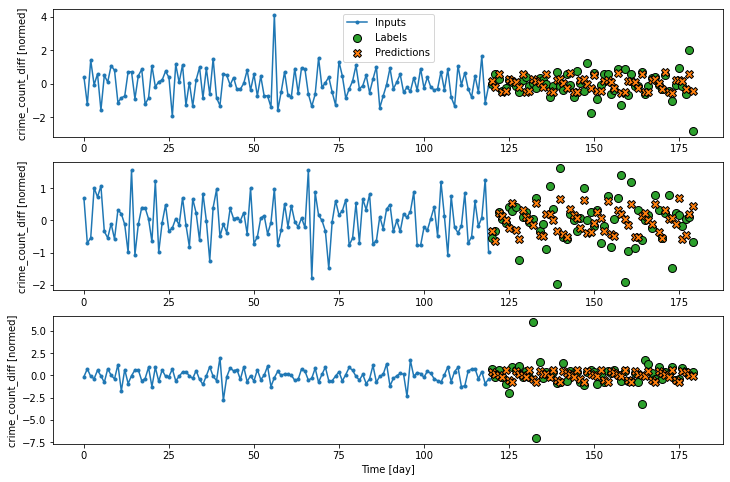

In [59]:
window.plot(model)

We would like to compare the performance of the selected LSTM model against Facebook Prophet. To do so, we create six windows each with 120 days as inputs (historical crime rate and the other 5 features) and 60 days as labels (crime rate to be predicted). The six prediction windows will cover the last 360 days of data in our original crime rate dataframe.<br>
Facebook Prophet only requires historical crime rate data as inputs and does not use the other features. We however use the entire historical crime data (before prediction period) for training the Facebook Prophet model for each of the six prediction windows.

In [60]:
prediction_window1 = WindowGenerator(test_df=test_df[-180:],
    input_width=120, label_width=60, shift=60,
    label_columns=['crime_count_diff'])
prediction_window2 = WindowGenerator(test_df=test_df[-240:-60],
    input_width=120, label_width=60, shift=60,
    label_columns=['crime_count_diff'])
prediction_window3 = WindowGenerator(test_df=test_df[-300:-120],
    input_width=120, label_width=60, shift=60,
    label_columns=['crime_count_diff'])
prediction_window4 = WindowGenerator(test_df=test_df[-360:-180],
    input_width=120, label_width=60, shift=60,
    label_columns=['crime_count_diff'])
prediction_window5 = WindowGenerator(test_df=test_df[-420:-240],
    input_width=120, label_width=60, shift=60,
    label_columns=['crime_count_diff'])
prediction_window6 = WindowGenerator(test_df=test_df[-480:-300],
    input_width=120, label_width=60, shift=60,
    label_columns=['crime_count_diff'])

In [61]:
predictions1 = model.predict(prediction_window1.test)
predictions2 = model.predict(prediction_window2.test)
predictions3 = model.predict(prediction_window3.test)
predictions4 = model.predict(prediction_window4.test)
predictions5 = model.predict(prediction_window5.test)
predictions6 = model.predict(prediction_window6.test)

In [62]:
predictions_orig1 = (predictions1 * train_std['crime_count_diff']) \
                                     + train_mean['crime_count_diff']
predictions_orig2 = (predictions2 * train_std['crime_count_diff']) \
                                     + train_mean['crime_count_diff']
predictions_orig3 = (predictions3 * train_std['crime_count_diff']) \
                                     + train_mean['crime_count_diff']
predictions_orig4 = (predictions4 * train_std['crime_count_diff']) \
                                     + train_mean['crime_count_diff']
predictions_orig5 = (predictions5 * train_std['crime_count_diff']) \
                                     + train_mean['crime_count_diff']
predictions_orig6 = (predictions6 * train_std['crime_count_diff']) \
                                     + train_mean['crime_count_diff']

In [63]:
pred1 = np.r_[df_new['crime_count'][-61], predictions_orig1.reshape(60)].cumsum()
pred2 = np.r_[df_new['crime_count'][-121], predictions_orig2.reshape(60)].cumsum()
pred3 = np.r_[df_new['crime_count'][-181], predictions_orig3.reshape(60)].cumsum()
pred4 = np.r_[df_new['crime_count'][-241], predictions_orig4.reshape(60)].cumsum()
pred5 = np.r_[df_new['crime_count'][-301], predictions_orig5.reshape(60)].cumsum()
pred6 = np.r_[df_new['crime_count'][-361], predictions_orig6.reshape(60)].cumsum()

In [64]:
MAE1 = mean_absolute_error(df_new[-60:]['crime_count'], pred1[1:])
MAE2 = mean_absolute_error(df_new[-120:-60]['crime_count'], pred2[1:])
MAE3 = mean_absolute_error(df_new[-180:-120]['crime_count'], pred3[1:])
MAE4 = mean_absolute_error(df_new[-240:-180]['crime_count'], pred4[1:])
MAE5 = mean_absolute_error(df_new[-300:-240]['crime_count'], pred5[1:])
MAE6 = mean_absolute_error(df_new[-360:-300]['crime_count'], pred6[1:])

We visualize the sixth prediction period below.

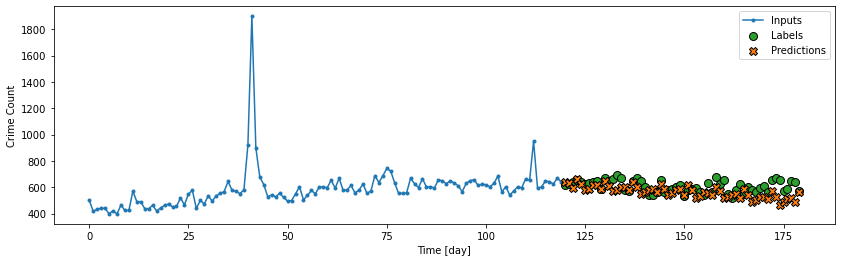

In [65]:
plt.figure(figsize=(14, 4))
plt.plot(prediction_window1.input_indices, df_new[-480:-360]['crime_count'],
             label='Inputs', marker='.', zorder=-10)
plt.scatter(prediction_window1.label_indices, df_new[-360:-300]['crime_count'],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
plt.scatter(prediction_window1.label_indices, pred6[1:],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
plt.legend()
plt.ylabel('Crime Count')
plt.xlabel('Time [day]')
plt.show()

We now do the modeling and predictions using Facebook Prophet.

In [66]:
df = df_new['crime_count'].reset_index()

In [67]:
df = df.rename(columns={"Date": "ds", "crime_count": "y"})

In [68]:
m1 = Prophet()
m1.fit(df[:-60])
m2 = Prophet()
m2.fit(df[:-120])
m3 = Prophet()
m3.fit(df[:-180])
m4 = Prophet()
m4.fit(df[:-240])
m5 = Prophet()
m5.fit(df[:-300])
m6 = Prophet()
m6.fit(df[:-360])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -34.023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19274.9    0.00151135       1554.15      0.3893      0.3893      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       19309.6    0.00187979       524.035           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         19315    0.00250229       438.635      0.6549      0.6549      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     391       19318.9   2.55378e-05       140.741   1.197e-07       0.001      495  LS failed, Hessian reset 
     399       19319.1   0.000182338       182.186      0.7788      0.7788      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       19320.4    0.00460528     

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -49.2402
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19100.9    0.00168323       535.396      0.9273      0.9273      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       19137.3    0.00746704       919.564           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     273       19145.2   3.72612e-05       186.108    1.06e-07       0.001      376  LS failed, Hessian reset 
     299       19146.7   0.000781928       280.777           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       19148.4    0.00027552       103.853           1           1      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       19149.3   8.55222e-05    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -58.6122
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18952.1    0.00369536       443.454      0.6164      0.6164      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         18971     0.0111617       570.504           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18973.9   2.54093e-05       86.6406           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       18974.7   1.36122e-05       76.0511   1.241e-07       0.001      506  LS failed, Hessian reset 
     399       18974.8    0.00143771       205.092           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     448       18975.8   5.04419e-05    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -38.9684
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18751.4     0.0174871       820.222           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18786.1    0.00263962       670.116           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18791.9    0.00147807       386.191      0.3761      0.3761      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       18794.4   3.26022e-05       163.156   1.137e-07       0.001      485  LS failed, Hessian reset 
     399         18795   0.000661945       168.452           1           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     459       18795.5   1.19096e-05    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -39.4371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18600.2     0.0276276       1335.38           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         18613    0.00219553       609.955           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18617.6    0.00392153       248.092       8.953      0.8953      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       18618.6   1.02478e-05       55.9209   1.277e-07       0.001      501  LS failed, Hessian reset 
     399       18618.6   0.000545664       212.717      0.6319           1      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       18619.4   0.000216335    

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18440.2    0.00265676       431.678      0.8614      0.8614      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18454.3    0.00325269       251.541           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18456.8   7.51588e-05       81.1486      0.3085           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       18457.3   2.91361e-05       100.814   9.619e-08       0.001      498  LS failed, Hessian reset 
     399       18457.7   6.73645e-05       71.6894      0.1761      0.1761      526   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     440       18457.8    2.6978e-05       141.936   2.035e-07       0.001      6

In [69]:
future1 = m1.make_future_dataframe(periods=60)
future2 = m2.make_future_dataframe(periods=60)
future3 = m3.make_future_dataframe(periods=60)
future4 = m4.make_future_dataframe(periods=60)
future5 = m5.make_future_dataframe(periods=60)
future6 = m6.make_future_dataframe(periods=60)

In [70]:
forecast1 = m1.predict(future1)
forecast1 = forecast1[['ds', 'yhat']].tail(60)

forecast2 = m2.predict(future2)
forecast2 = forecast2[['ds', 'yhat']].tail(60)

forecast3 = m3.predict(future3)
forecast3 = forecast3[['ds', 'yhat']].tail(60)

forecast4 = m4.predict(future4)
forecast4 = forecast4[['ds', 'yhat']].tail(60)

forecast5 = m5.predict(future5)
forecast5 = forecast5[['ds', 'yhat']].tail(60)

forecast6 = m6.predict(future6)
forecast6 = forecast6[['ds', 'yhat']].tail(60)

In [71]:
MAE_FP_1 = mean_absolute_error(df_new[-60:]['crime_count'], forecast1['yhat'])
MAE_FP_2 = mean_absolute_error(df_new[-120:-60]['crime_count'], forecast2['yhat'])
MAE_FP_3 = mean_absolute_error(df_new[-180:-120]['crime_count'], forecast3['yhat'])
MAE_FP_4 = mean_absolute_error(df_new[-240:-180]['crime_count'], forecast4['yhat'])
MAE_FP_5 = mean_absolute_error(df_new[-300:-240]['crime_count'], forecast5['yhat'])
MAE_FP_6 = mean_absolute_error(df_new[-360:-300]['crime_count'], forecast6['yhat'])

We compare the performance of the LSTM and Facebook Prophet models (period 1 is the last 60 days, period 2 is the 60 days before that, and so on).

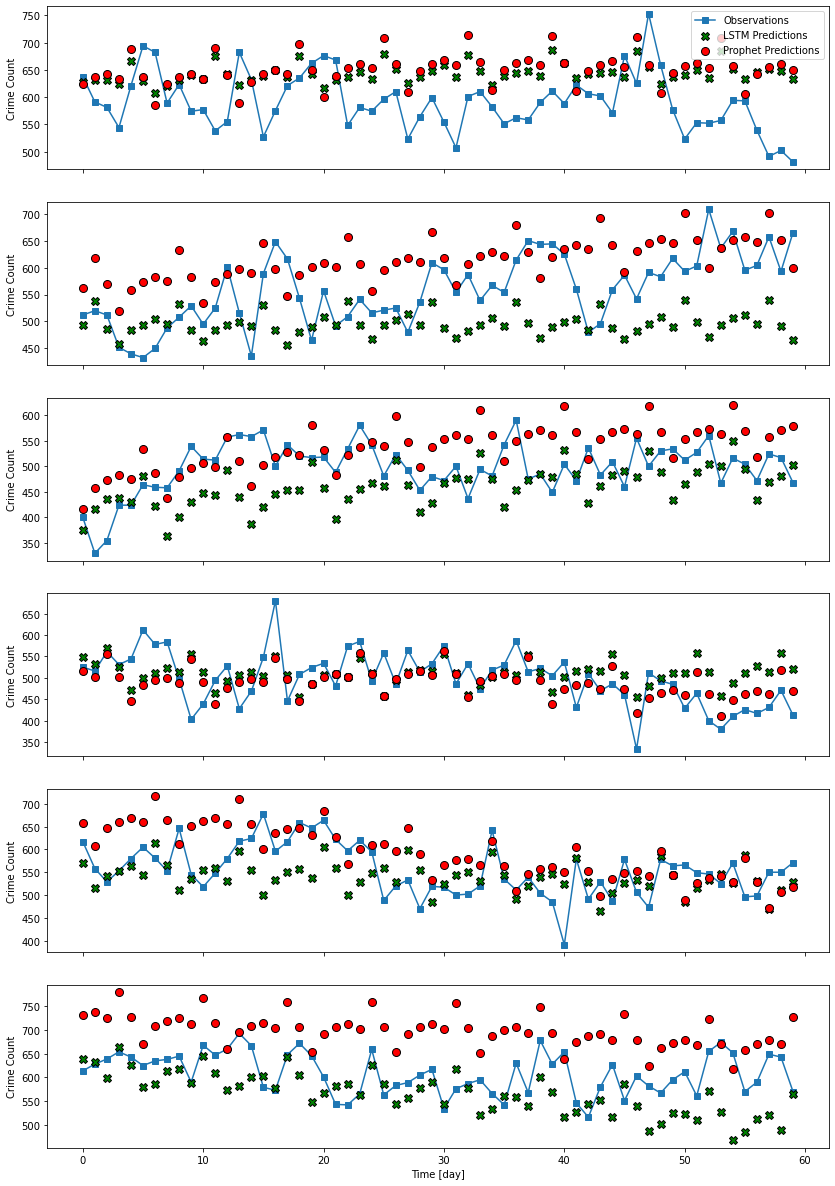

In [72]:
fig, ax = plt.subplots(6, 1, figsize=(14, 21), sharex=True)

ax[0].plot(np.arange(60), df_new[-60:]['crime_count'],
             label='Observations', marker='s', zorder=-10)
ax[0].scatter(np.arange(60), pred1[1:],
                  marker='X', edgecolors='k', label='LSTM Predictions',
                  c='g', s=64)
ax[0].scatter(np.arange(60), forecast1['yhat'],
                  marker='o', edgecolors='k', label='Prophet Predictions',
                  c='r', s=64)
ax[0].legend()
ax[0].set_ylabel('Crime Count')

ax[1].plot(np.arange(60), df_new[-120:-60]['crime_count'],
             label='Observations', marker='s', zorder=-10)
ax[1].scatter(np.arange(60), pred2[1:],
                  marker='X', edgecolors='k', label='LSTM Predictions',
                  c='g', s=64)
ax[1].scatter(np.arange(60), forecast2['yhat'],
                  marker='o', edgecolors='k', label='Prophet Predictions',
                  c='r', s=64)
ax[1].set_ylabel('Crime Count')

ax[2].plot(np.arange(60), df_new[-180:-120]['crime_count'],
             label='Observations', marker='s', zorder=-10)
ax[2].scatter(np.arange(60), pred3[1:],
                  marker='X', edgecolors='k', label='LSTM Predictions',
                  c='g', s=64)
ax[2].scatter(np.arange(60), forecast3['yhat'],
                  marker='o', edgecolors='k', label='Prophet Predictions',
                  c='r', s=64)
ax[2].set_ylabel('Crime Count')

ax[3].plot(np.arange(60), df_new[-240:-180]['crime_count'],
             label='Observations', marker='s', zorder=-10)
ax[3].scatter(np.arange(60), pred4[1:],
                  marker='X', edgecolors='k', label='LSTM Predictions',
                  c='g', s=64)
ax[3].scatter(np.arange(60), forecast4['yhat'],
                  marker='o', edgecolors='k', label='Prophet Predictions',
                  c='r', s=64)
ax[3].set_ylabel('Crime Count')

ax[4].plot(np.arange(60), df_new[-300:-240]['crime_count'],
             label='Observations', marker='s', zorder=-10)
ax[4].scatter(np.arange(60), pred5[1:],
                  marker='X', edgecolors='k', label='LSTM Predictions',
                  c='g', s=64)
ax[4].scatter(np.arange(60), forecast5['yhat'],
                  marker='o', edgecolors='k', label='Prophet Predictions',
                  c='r', s=64)
ax[4].set_ylabel('Crime Count')

ax[5].plot(np.arange(60), df_new[-360:-300]['crime_count'],
             label='Observations', marker='s', zorder=-10)
ax[5].scatter(np.arange(60), pred6[1:],
                  marker='X', edgecolors='k', label='LSTM Predictions',
                  c='g', s=64)
ax[5].scatter(np.arange(60), forecast6['yhat'],
                  marker='o', edgecolors='k', label='Prophet Predictions',
                  c='r', s=64)
ax[5].set_ylabel('Crime Count')

plt.xlabel('Time [day]')
plt.show()

In [73]:
pd.DataFrame({'Period': [1, 2, 3, 4, 5, 6], 
              'MAE for LSTM': [MAE1, MAE2, MAE3, MAE4, MAE5, MAE6],
              'MAE for Prophet': [MAE_FP_1, MAE_FP_2, MAE_FP_3, MAE_FP_4, MAE_FP_5, MAE_FP_6]})

,Period,MAE for LSTM,MAE for Prophet
0,1,68.646848,78.217711
1,2,75.028736,70.562665
2,3,54.398343,55.233943
3,4,53.458665,46.158135
4,5,48.034061,57.068427
5,6,52.550800,91.567163


We see that the LSTM model performs better than the Prophet model for four of the six periods. Overall, the LSTM model proves more reliable in predictions with an average MAE of 7.78 less than the Prophet model.